In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from rtree import index
import datetime
import gc

In [2]:
mc_data = pd.read_json('../datasets/SciFi_200000_Clean_TrackStudy.json')

In [3]:
mc_data.head()

,MCParticleID,MC_Hit_X,MC_Hit_Y,MC_Hit_Z,PrHit_LHCbID,PrHit_Xat0,PrHit_Zat0,PrHit_isX,PrHit_planeCode,PrHit_w2,PrHit_yMax,PrHit_yMin,PrHit_zone,event
0,11,"[-796.1949462891, -867.6917114258, -939.954467...","[-547.6024169922, -546.8995361328, -545.967590...","[7824.02734375, 7894.0302734375, 7964.03417968...","[265206, 330845, 330841, 395541, 462685, 46268...","[-795.9899902344, -820.4680786133, -819.589782...","[7825.9995117188, 7895.9995117188, 7896, 7966....","[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, ...","[34.6020736694, 400, 400, 34.6020736694, 400, ...","[-0.6218893528, 1.2071897984, 1.1309289932, -1...","[-2424.6062011719, -2413.5529785156, -2413.629...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21905
1,211,"[-459.2020568848, -470.9031677246, -482.680023...","[196.2071990967, 197.9016876221, 199.592437744...","[7826.7060546875, 7896.7124023438, 7966.71875,...","[296699, 360603, 427785, 491644, 559275, 62640...","[-459.3350219727, -488.1535644531, -465.221313...","[7825.9995117188, 7895.9995117188, 7966, 8036....","[1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]","[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 11]","[34.6020736694, 34.6020736694, 34.6020736694, ...","[2425.3623046875, 2435.2121582031, 2398.291748...","[1.3780976534, 20.4519348145, -16.46849823, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",21905
2,211,"[232.5449523926, 238.9716949463, 245.422760009...","[-366.5329589844, -369.8256225586, -373.114532...","[7824.6791992188, 7894.66796875, 7964.65673828...","[279425, 345065, 410418, 541820, 606949, 67280...","[232.5400085449, 271.38671875, 212.8891143799,...","[7825.9995117188, 7895.9995117188, 7966, 8507....","[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1]","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 11]","[34.6020736694, 34.6020736694, 34.6020736694, ...","[-0.6218893528, -1.3813185692, -5.6900262833, ...","[-2424.6062011719, -2416.1416015625, -2420.450...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21905
3,211,"[-742.7728881836, -756.0042724609, -769.291320...","[548.9400634766, 553.8966674805, 558.841369628...","[7827.9760742188, 7897.994140625, 7968.0126953...",[],[],[],[],[],[],[],[],[],21905
4,211,"[-1682.0789794922, -1712.3188476562, -1742.736...","[157.9889678955, 159.4016723633, 160.832138061...","[7826.568359375, 7896.5737304688, 7966.5795898...",[],[],[],[],[],[],[],[],[],21905


In [4]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event


In [5]:
mc_hits = mc_data.values
print('Shape MC_Hits: %s' % str(mc_hits.shape))

Shape MC_Hits: (200000, 14)


In [6]:
# Parameters for the 2-hit combination
L0_AlphaCorr = [120.64 , 510.64 , 730.64]
L0_tolHp = [280.0 , 540.0 , 1080.0]

# Parameters for the 3-hit combination
x0Corr = [0.002152 , 0.001534 , 0.001834]
X0SlopeChange = [400. , 500. , 500.]
x0Cut = [1500.0 , 4000. , 6000.]
TolAtX0Cut = [4.5 , 8.0 , 14.0]
ToleranceX0Up = [0.75, 0.75 , 0.75]
X0SlopeChangeDown = [2000.0 , 2000.0 , 2000.0]
TolAtX0CutOpp = [0.75 , 2.0 , 7.0]
ToleranceX0Down = [0.75 , 0.75 , 0.75]
maxParabolaSeedHits = 12
S1 = np.zeros(3)
S2 = np.zeros(3)
dRatio = -0.000262
dRatioPar = [0.000267957, -8.651e-06,  4.60324e-05]
m_zReference = 8520
TolXRemaining = [1.0 , 1.0 , 1.0]
m_minXPlanes = 4
m_maxChi2HitsX = [5.5,5.5,5.5]

for case in range(0,3):
    S1[case] = (TolAtX0Cut[case] - ToleranceX0Up[case]) / (x0Cut[case] - X0SlopeChange[case])  
    S2[case] = (TolAtX0CutOpp[case] - ToleranceX0Down[case]) / (x0Cut[case] - X0SlopeChangeDown[case])

# Extra constants
max_x = 3182.8356933594
min_x = -3182.8576660156
min_y = -2438.6506347656
max_y = 2438.6506347656

In [7]:
all_hits = np.zeros((3000000, 13))
i = 0
hits_len = 0
empty_particles = []
for hits in mc_hits:
    if ((len(hits[4]) > 1)):
        hits_len += 1
        hash_val = hash(tuple(hits[1]))
        for j in range(0, len(hits[4])):
            hit = np.zeros(13)
            for k in range(0,9):
                hit[k + 1] = hits[k + 4][j]
            hit[10] = hits[13]
            hit[0] = hits[0]
            hit[11] = hash_val
            #hit[12] = hits[17]
            all_hits[i] = hit
            i += 1
# Removing empty values, as some hits in the mc_hits dataset do not contain readings (PrHit...)
all_hits = all_hits[all_hits[:,0] != 0]
zLays = np.zeros(12)
for i in range(0,12):
    zLays[i] = np.unique(all_hits[all_hits[:,5] == i][:,3])[0]
print("Hash unique check: %d/%d" % (len(np.unique(all_hits[:,11])), hits_len))

Hash unique check: 141803/141803


In [8]:
zLays

array([7825.99951172, 7895.99951172, 7966.        , 8036.00048828,
       8507.99902344, 8577.99902344, 8647.99902344, 8718.00097656,
       9192.99902344, 9262.99902344, 9332.99902344, 9403.00097656])

In [9]:
def solveParabola(hit1, hit2, hit3, a, b, c):
    z1 = hit1[3] - m_zReference;
    z2 = hit2[3] - m_zReference;
    z3 = hit3[3] - m_zReference;
    x1 = hit1[2];
    x2 = hit2[2];
    x3 = hit3[2];
    corrZ1 = 1. + dRatio * z1;
    corrZ2 = 1. + dRatio * z2;
    corrZ3 = 1. + dRatio * z3;
    det = (z1*z1)*corrZ1*z2 + z1*(z3*z3)*corrZ3 + (z2*z2)*corrZ2*z3 - z2*(z3*z3)*corrZ3 - z1*(z2*z2)*corrZ2 - z3*(z1*z1)*corrZ1;
    recdet = 1./det;
    if( np.abs(det) < 1e-8 ):
        b1 = (x3-x1)/(z3-z1);
        c1 = x1 - b1*z1;
        a1 = 0.;
        return a1, b1, c1;
    det1 = (x1)*z2 + z1*(x3) + (x2)*z3 - z2*(x3) - z1*(x2) - z3*(x1);
    det2 = (z1*z1)*corrZ1*x2 + x1*(z3*z3)*corrZ3 + (z2*z2)*corrZ2*x3 - x2*(z3*z3)*corrZ3 - x1*(z2*z2)*corrZ2 - x3*(z1*z1)*corrZ1;
    det3 = (z1*z1)*corrZ1*z2*x3 + z1*(z3*z3)*corrZ3*x2 +(z2*z2)*corrZ2*z3*x1 - z2*(z3*z3)*corrZ3*x1 - z1*(z2*z2)*corrZ2*x3 - z3*(z1*z1)*corrZ1*x2;
    a1 = recdet*det1;
    b1 = recdet*det2;
    c1 = recdet*det3;
    return a1, b1, c1;

In [10]:
def fitXProjection(hits, case):
    if (len(hits) < m_minXPlanes):
        return False
    mat = np.zeros(6)
    rhs = np.zeros(3)
    for i in range(0,3):
        for hit in hits:
            w = hit[6]
            dz = 0.001*(hit[3] - m_zReference)
            deta = dz*dz*(1. + dRatio*dz);
            dist = track.distance( *itH );
            mat[0]+= w;
            mat[1]+= w * dz
            mat[2]+= w * dz * dz;
            mat[3]+= w * deta
            mat[4]+= w * dz * deta
            mat[5]+= w * deta * deta;
            rhs[0]+= w * dist
            rhs[1]+= w * dist * dz;
            rhs[2]+= w * dist * deta;
    

In [11]:
def arrayHybrid(identifier):
    start_time = datetime.datetime.now()
    events = all_events[toSplit*identifier:toSplit*(identifier+1)]
    list_founded = np.zeros(len(events))
    # For each event
    xHitsLists_events =[]
    for event in events:
        # Get all hits from a given event
        event_hits = all_hits[(all_hits[:,10] == event)]
        list_hits = []
        for case in range(0,3):

            if case > 1:
                first_layer = 3
            else:
                first_layer = 0

            if case == 1:
                last_layer = 8
            else:
                last_layer = 11

            invZlZf = 1.0 / (zLays[last_layer] - zLays[first_layer])
            invZfirst = 1.0 / (zLays[first_layer])
            xHitList = []

            # Upper part and then lower
            for k in range(0,2):
                first_layer_list = event_hits[(event_hits[:,5] == first_layer) & (event_hits[:,9] == k)]
                last_layer_list = event_hits[(event_hits[:,5] == last_layer) & (event_hits[:,9] == k)]
                middle_layer_list = event_hits[(event_hits[:,5] == 4) & (event_hits[:,9] == k)]
                for f_hit in first_layer_list:
                    collected = []
                    xHitsLists = []
                    tx_inf = (f_hit[2] * invZfirst)
                    xProjeInf = tx_inf * zLays[last_layer]
                    maxXl = xProjeInf + tx_inf * L0_AlphaCorr[case] + L0_tolHp[case]
                    minXl = xProjeInf + tx_inf * L0_AlphaCorr[case] - L0_tolHp[case]
                    for temp in last_layer_list:
                        if (minXl <= temp[2]) and (temp[2] <= maxXl):
                            collected.append(temp)
                    for l_hit in collected:
                        m_tmp = (l_hit[2] - f_hit[2]) * invZlZf
                        x0 = f_hit[2] - (m_tmp * zLays[first_layer])
                        CorrX0 = x0Corr[case] * x0;
                        if (x0 > 0.0):
                            if (x0 > X0SlopeChange[case]):
                                min = -S1[case] * (x0 - X0SlopeChange[case])
                                max = S2[case] * (x0 - X0SlopeChangeDown[case])
                            else:
                                min = -ToleranceX0Up[case]
                                max = ToleranceX0Down[case]
                        else:
                            if (x0 < -X0SlopeChange[case]):
                                min = -S1[case] * (x0 + X0SlopeChange[case])
                                max = S2[case] * (x0 +  X0SlopeChangeDown[case])
                            else:
                                min = -ToleranceX0Down[case]
                                max = ToleranceX0Up[case]
                        xProjected = x0 + l_hit[3] * m_tmp;
                        xProjectedCorrected = xProjected + CorrX0 
                        xMin = xProjectedCorrected + min ;
                        xMax = xProjectedCorrected + max ;
                        if( xMin > xMax):
                            xMin,xMax = xMax,xMin
                        found_tmp = []
                        for m_hit in middle_layer_list:
                            if (xMin <= m_hit[2]) and (m_hit[2] <= xMax):
                                a,b,c = solveParabola(f_hit, m_hit, l_hit, 0,0,0)
                                xHits = {}
                                for layer in range(first_layer,last_layer + 1):
                                    if (layer == m_hit[5]):
                                        continue
                                    dz = zLays[layer] - m_zReference;
                                    xAtZ= a * dz * dz * (1. + dRatio* dz) + b * dz + c
                                    xMaxAtZ = xAtZ + TolXRemaining[case]
                                    xMinAtZ = xAtZ - TolXRemaining[case]
                                    actual_layer = event_hits[(event_hits[:,5] == layer) & (event_hits[:,9] == k)]
                                    xHitLayer = []
                                    for hit in actual_layer:
                                        if (xMinAtZ <= hit[2]) and (hit[2] <= xMaxAtZ):
                                            xHitLayer.append(hit)
                                    if (len(xHitLayer) > 0):
                                        xHits[layer] = xHitLayer
                                xHits[first_layer] = f_hit
                                xHits[last_layer] = l_hit
                                xHits[m_hit[5]] = m_hit
                                xHitsLists.append(xHits)
                    xHitList.append(xHitsLists)
            xHitsLists_events.append(xHitList)
    end = datetime.datetime.now()
    print("Thread %d took: %d s" % (identifier, (end - start_time).seconds))
    gc.collect()
    return xHitsLists_events

In [16]:
def rtreeHybrid(identifier):
    i = 0
    found = []
    start_time = datetime.datetime.now()
    events = all_events[toSplit*identifier:toSplit*(identifier+1)]
    xHitsLists_events =[]
    for event in events:
        # Get all hits from a given event
        p = index.Property()
        p.dimension = 2
        idx = index.Index(properties=p, interleaved=False)
        for hit in all_hits[(all_hits[:,10] == event)]:
            if (hit[9] == 0):
                idx.insert(int(hit[11]), (float(hit[2]), float(hit[2]), float(hit[5]), float(hit[5])), hit)
        found_tmp = []
        xHitList = []
        for case in range(0,3):
            
            if case > 1:
                first_layer = 3
            else:
                first_layer = 0
                
            if case == 1:
                last_layer = 8
            else:
                last_layer = 11
            
            invZlZf = 1.0 / (zLays[last_layer] - zLays[first_layer])
            invZfirst = 1.0 / (zLays[first_layer])
            first_layer_list = list(idx.intersection((min_x, max_x, first_layer, first_layer), objects='raw'))
            for f_hit in first_layer_list:
                collected = []
                xHitsLists = []
                tx_inf = (f_hit[2] * invZfirst)
                xProjeInf = tx_inf * zLays[last_layer]
                maxXl = xProjeInf + tx_inf * L0_AlphaCorr[case] + L0_tolHp[case]
                minXl = xProjeInf + tx_inf * L0_AlphaCorr[case] - L0_tolHp[case]
                collected = list(idx.intersection((minXl, maxXl, last_layer, last_layer), objects='raw'))
                for l_hit in collected:
                    tx_pickedcombination = (l_hit[2] - f_hit[2]) * invZlZf
                    x0 = f_hit[2] - (tx_pickedcombination * zLays[first_layer])
                    x0new = x0 * ( 1. + x0Corr[case]);
                    CorrX0 = x0Corr[case] * x0;
                    if (x0 > 0.0):
                        if (x0 > X0SlopeChange[case]):
                            min = -S1[case] * (x0 - X0SlopeChange[case])
                            max = S2[case] * (x0 - X0SlopeChangeDown[case])
                        else:
                            min = -ToleranceX0Up[case]
                            max = ToleranceX0Down[case]
                    else:
                        if (x0 < -X0SlopeChange[case]):
                            min = -S1[case] * (x0 + X0SlopeChange[case])
                            max = S2[case] * (x0 +  X0SlopeChangeDown[case])
                        else:
                            min = -ToleranceX0Down[case]
                            max = ToleranceX0Up[case]
                            
                            
                    xProjected = x0 + zLays[4] * tx_pickedcombination;
                    xProjectedCorrected = xProjected + CorrX0 
                    xMin = xProjectedCorrected + min ;
                    xMax = xProjectedCorrected + max ;
                    if( xMin > xMax):
                        xMin,xMax = xMax,xMin
                    founded = list(idx.intersection((xMin, xMax, 4, 4),  objects='raw'))

                    xProjected = x0 + zLays[7] * tx_pickedcombination;
                    xProjectedCorrected = xProjected + CorrX0 
                    xMin = xProjectedCorrected + min ;
                    xMax = xProjectedCorrected + max ;
                    if( xMin > xMax):
                        xMin,xMax = xMax,xMin
                    founded_sec = list(idx.intersection((xMin, xMax, 7, 7),  objects='raw'))
                    for f in founded_sec:
                        founded.append(f)
                        
                    if len(founded) == 0:
                        continue
                        
                    founded = sorted(founded, key = lambda p: np.abs(p[2] - (x0new + p[3]*tx_pickedcombination)))
                    
                    toExit = 0
                    for m_hit in founded:
                        a,b,c = solveParabola(f_hit, m_hit, l_hit, 0,0,0)
                        xHits = []
                        xHits.append(f_hit)
                        fired = False
                        for layer in [0,3,4,7,8,11]:
                            if (layer == m_hit[5]):
                                xHits.append(m_hit)
                                continue
                            if (layer == first_layer) or (layer == last_layer):
                                continue
                            dz = zLays[layer] - m_zReference;
                            xAtZ= a * dz * dz * (1. + dRatio * dz) + b * dz + c
                            xMaxAtZ = xAtZ + TolXRemaining[case];
                            xMinAtZ = xAtZ - TolXRemaining[case];
                            toSave = list(idx.intersection((xMinAtZ, xMaxAtZ, layer, layer), objects='raw'))
                            if (len(toSave) > 0):
                                fired = True
                                toSave = sorted(toSave, key = lambda p: np.abs(p[2] - xAtZ))[0]
                                xHits.append(toSave)
                        xHits.append(l_hit)
                        if (fired):
                            xHitsLists.append(xHits)
                xHitList.append(xHitsLists)
        xHitsLists_events.append(xHitList)
    end = datetime.datetime.now()
    print("Thread %d took: %d s" % (identifier, (end - start_time).seconds))
    gc.collect()
    return xHitsLists_events

In [17]:
np.unique(mc_hits[:,13]).shape

(929,)

In [18]:
all_events = np.unique(mc_hits[:,13])[:14]
toSplit = int(np.round(len(all_events) / 14))
pool = Pool(processes=7)
#map doWork to availble Pool processes
results = pool.map(rtreeHybrid, ( 0, 1, 2, 3, 4, 5, 6))
pool.close()
pool.join()

25
83
40
61
49
25
30
40
106
166
49
43
61
Thread 5 took: 1 s
83
60
Thread 6 took: 1 s
106
74
Thread 0 took: 2 s
96
166
121
Thread 1 took: 3 s


Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-12:
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-8:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **s

KeyboardInterrupt: 

In [19]:
total = 0
mean = 0
unique = {}
#fig = plt.figure(figsize=(19, 8))
#ax = fig.add_subplot(111)
num_unique = 0

for core in results:
    for event in core:
        for result in event:
            for hit in result:
                valid = 0
                equal = 0
                first = hit[0]
                X_f = []
                Z_f = []
                X_l = []
                Z_l = []
                
                if (unique.get(first[11]) == None):
                    unique[first[11]] = [hit,0]
                else:
                    num_unique += 1
                    continue
                    #for h in hit:
                    #    X_f.append(h[2])
                    #    Z_f.append(h[3])
                    #for h in unique.get(first[11])[0]:
                    #    X_l.append(h[2])
                    #    Z_l.append(h[3])
                    #
                    #equal = 1
                                    
                for h in hit:
                    if (h[5] != first[5]) and (first[11] == h[11]):
                        valid += 1
                    
                if valid > 0:
                    unique[first[11]][1] = valid
                    mean += 1
                
                total += 1
                    
print(mean/total)
print(total)
print(total/num_unique)
print(num_unique)

0.5102974828375286
437
0.0994538006372326
4394


NameError: name 'hitSet' is not defined

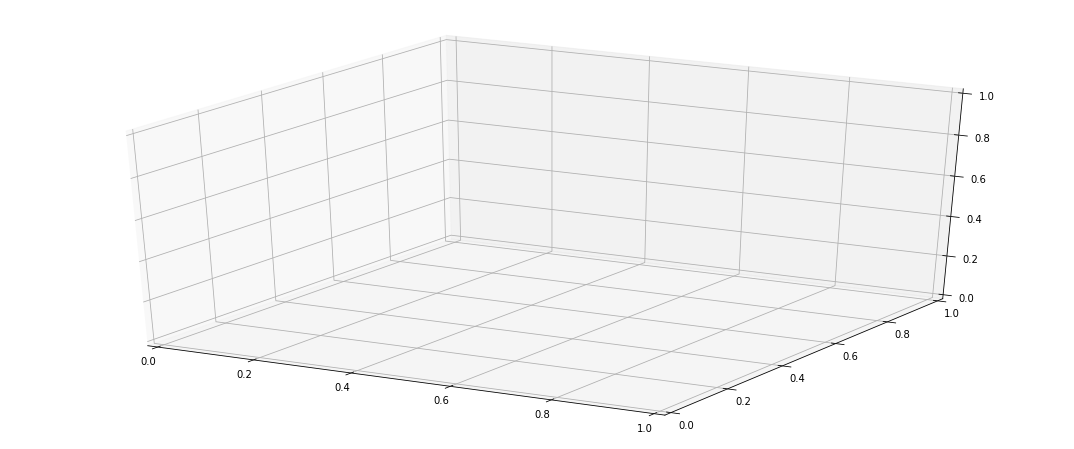

In [18]:
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111, projection='3d')

i = 0
# Iterate through all the particles keys obtained 
for particle in hitSet:

    X = np.array(particle[50]).astype(float)
    Y = np.array(particle[51]).astype(float)
    Z = np.array(particle[52]).astype(float)

    ax.plot(X, Z, Y)

    i = i + 1
    if i == max:
        break

ax.view_init(elev=elev, azim=angle)
ax.grid()
plt.show()

In [ ]:
# With only the first one
0.2830942288881643
12268

# With 3
0.2663297467666558
36804

# With 5
0.24873655037495923
73608

# With 10
0.2400998903281264
134948